## Generate Training/Testing Data

This notebook will parse through the preprocessed data from preprocess.ipynp and break it into training and testing data sets. The general strategy will be to create windows of length 1 second (125 points), with a sliding length of 10 points.

Import stuff

In [1]:
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import numpy as np
import pywt
import numpy as np
from memory_profiler import profile

#!pip install googledrivedownloader
#from google_drive_downloader import GoogleDriveDownloader as gdd

Define some constants

In [2]:
#window size is 1 second (256 points)
WIN_LEN = 256

#amount of points to slide forward for next window
WIN_SLIDE = 16

#at least 75% of the indices within a given window should be within the valid indices
#TODO: is this a good threshold? the lower this number is, it could affect performance quite a bit
MIN_VALID_PERC = 0.9

#define the frequencies for the cwt
wavelet = 'morl'
scales = np.arange(2,64)  #this corresponds to ~1.5Hz - 50Hz
wavelet_freqs = pywt.scale2frequency(wavelet, scales)*256

Download the preprocessed data (as generated from preprocess.ipynp). Note that this is ~500MB so it will take some time.

In [3]:
#the link to download data_labels_preprocessed.pkl
#file_id = '1vcBM0UOxoUhUUHTKzNDpRFVq9pn5eA0g'

#load in the data and labels
#gdd.download_file_from_google_drive(file_id=file_id, dest_path='./data_labels_preprocessed.pkl')
#df = pd.read_pickle('data_labels_preprocessed.pkl')

Define a function to window the data

In [4]:
def get_windows(row, activity):
    #record_name = row['record_name']
    #print(record_name)

    #check if there is no data here
    if row[activity] is None: return []

    #set up the data and labels
    coefficients = row[activity]['cwt']
    data = row[activity]['ecg']
    N = np.shape(coefficients)[1]
    QRS_labels = row[activity]['qrs']
    r_labels = row[activity]['rr']
    #print(N)
    N=min(40000,N)


    windows = []
    #now loop through windows of length WIN_LEN and generate windows with labels

    for i in range(0, N-WIN_LEN, WIN_SLIDE):
        #get the current window indices
        tmp_inds = range(i,i+WIN_LEN)

        #confirm that at least 90% of the points are within the valid indices
        #if sum(np.isin(tmp_inds, valid_inds))/WIN_LEN < MIN_VALID_PERC: continue

        #grab the data for this window
        tmp_win = coefficients[:,tmp_inds]
        tmp_labels = QRS_labels[tmp_inds]
        tmp_r= r_labels[tmp_inds]
        tmp_data = data[tmp_inds]
        
        #plot
        power = (abs(tmp_win))**2
        levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
        contourlevels = np.log2(levels)
        
        if i %100000== 0:
            plt.figure(figsize=(10,6))
            ax1 = plt.subplot(211)
            plt.plot(tmp_labels, 'b', label='Label')
            plt.plot(tmp_data, label='ECG')
            plt.legend(loc=1)
            ax2 = plt.subplot(212, sharex=ax1)
            plt.contourf(range(len(tmp_data)), wavelet_freqs, np.log2(power), contourlevels, extend='both', cmap='jet')
            plt.ylabel('Hz')
            plt.xlabel('Time (samples)')
            plt.tight_layout()
            #plt.savefig('cwt/%s_%s.png' % (record_name, channel), dpi=125)
            plt.show()
            plt.close()
        

        #add to list
        tmp_dict = {'window': tmp_win, 'label': tmp_labels, 'data': tmp_data, 'r': tmp_r}
        windows.append(tmp_dict)
    #print(len(windows))
    return windows




In [5]:
#faros = pd.read_pickle('./pickle/FAROS_preprocessed.pkl')
#sot= pd.read_pickle('./pickle/SOT_preprocessed.pkl')
#nex= pd.read_pickle('./pickle/NEXUS_preprocessed.pkl')
hex= pd.read_pickle('./pickle/FAROS_preprocessed.pkl')

Do the actual data windowing on each channel separately. Then combine both channels and keep 90% for training, 10% for testing

import gc
#window the data
RATIO = 0.9

train_sot,train_far,train_hex,train_nex= None,None,None,None
test_sot,test_far,test_hex,test_nex= None,None,None,None
#Faros
windows_far = faros.apply(get_windows, activity='rest', axis=1)
print(windows_far.shape)
windows_far = pd.DataFrame(windows_far)
print(windows_far.shape)
windows_far = pd.DataFrame([item for sublist in windows_far.values for item in sublist[0]])
print(windows_far.shape)
train_far = windows_far.iloc[0:int(len(windows_far)*RATIO)]
test_far = windows_far.iloc[int(len(windows_far)*RATIO)+1:]
#free up memory
faros = None
windows_far = None
gc.collect()
"""
#Sot
windows_sot = sot.apply(get_windows, activity='raw', axis=1)
windows_sot = pd.DataFrame(windows_sot)
windows_sot = pd.DataFrame([item for sublist in windows_sot.values for item in sublist[0]])
train_sot = windows_sot.iloc[0:int(len(windows_sot)*RATIO)]
test_sot = windows_sot.iloc[int(len(windows_sot)*RATIO)+1:]

#Nex
windows_nex = nex.apply(get_windows, activity='raw', axis=1)
windows_nex = pd.DataFrame(windows_nex)
windows_nex = pd.DataFrame([item for sublist in windows_nex.values for item in sublist[0]])
train_nex = windows_nex.iloc[0:int(len(windows_nex)*RATIO)]
test_nex = windows_nex.iloc[int(len(windows_nex)*RATIO)+1:]

#Hex
windows_hex = hex.apply(get_windows, activity='raw', axis=1)
windows_hex = pd.DataFrame(windows_hex)
windows_hex = pd.DataFrame([item for sublist in windows_hex.values for item in sublist[0]])
train_hex = windows_hex.iloc[0:int(len(windows_hex)*RATIO)]
test_hex = windows_hex.iloc[int(len(windows_hex)*RATIO)+1:]
"""

#combine the all channels
train = pd.concat((train_sot,train_far,train_hex,train_nex)).reset_index(drop=True)
train.to_pickle('train.pkl', protocol=4)
len_train=len(train)
train=None
gc.collect()
test = pd.concat((test_sot,test_far,test_hex,test_nex)).reset_index(drop=True)
test.to_pickle('test.pkl', protocol=4)
len_test=len(test)
test=None
gc.collect()

print('total number of windows: %i' % (len_train+len_test))



import gc
#window the data
RATIO = 0.9
#从1-13中random选择3个数
import random
random.seed(42)
channels = random.sample(range(1, 13), 3)
#将3个数转换成x00n的形式
channel_str = ['x00'+str(i) if i<10 else 'x0'+str(i) for i in channels]
print(channel_str)

train_sot,train_far,train_hex,train_nex= None,None,None,None
test_sot,test_far,test_hex,test_nex= None,None,None,None

continuous=False
ACTIVITY='rest'


#Faros
if continuous:
    windows_far = []
    windows_far_test = []
    for index,row in faros.iterrows():
        #print(row)
        temp = get_windows(row, activity=ACTIVITY)
        #如果记录属于CHANELS中的一个
        if index in channels:
            #合并
            windows_far_test.extend(temp)
            #save the data
            unit_test = pd.DataFrame(temp)
            unit_test.to_pickle('test_%s.pkl' % channel_str[channels.index(index)], protocol=4)
        else:
            windows_far.extend(temp)

    train_far = pd.DataFrame(windows_far)
    test_far = pd.DataFrame(windows_far_test)
    #free up memory
    windows_far_raw, windows_far, windows_far_test = None, None, None
    gc.collect()
else:
    windows_far_train = []
    windows_far_test = []
    for index,row in faros.iterrows():
        temp=get_windows(row, activity=ACTIVITY)
        #切分数据集+合并
        pivot=int(len(temp)*RATIO)
        windows_far_train.extend(temp[0:pivot])
        windows_far_test.extend(temp[pivot:])
    train_far = pd.DataFrame(windows_far_train)
    test_far = pd.DataFrame(windows_far_test)

#free up memory
faros = None
gc.collect()


"""
#Sot
windows_sot = sot.apply(get_windows, activity='raw', axis=1)
windows_sot = pd.DataFrame(windows_sot)
windows_sot = pd.DataFrame([item for sublist in windows_sot.values for item in sublist[0]])
train_sot = windows_sot.iloc[0:int(len(windows_sot)*RATIO)]
test_sot = windows_sot.iloc[int(len(windows_sot)*RATIO)+1:]

#Nex
windows_nex = nex.apply(get_windows, activity='raw', axis=1)
windows_nex = pd.DataFrame(windows_nex)
windows_nex = pd.DataFrame([item for sublist in windows_nex.values for item in sublist[0]])
train_nex = windows_nex.iloc[0:int(len(windows_nex)*RATIO)]
test_nex = windows_nex.iloc[int(len(windows_nex)*RATIO)+1:]

#Hex
windows_hex = hex.apply(get_windows, activity='raw', axis=1)
windows_hex = pd.DataFrame(windows_hex)
windows_hex = pd.DataFrame([item for sublist in windows_hex.values for item in sublist[0]])
train_hex = windows_hex.iloc[0:int(len(windows_hex)*RATIO)]
test_hex = windows_hex.iloc[int(len(windows_hex)*RATIO)+1:]
"""

#combine the all channels
train = pd.concat((train_sot,train_far,train_hex,train_nex)).reset_index(drop=True)
train.to_pickle('train.pkl', protocol=4)
len_train=len(train)
train=None
gc.collect()
test = pd.concat((test_sot,test_far,test_hex,test_nex)).reset_index(drop=True)
test.to_pickle('test.pkl', protocol=4)
len_test=len(test)
test=None
gc.collect()

print('total number of windows: %i' % (len_train+len_test))



['x011', 'x002', 'x001']


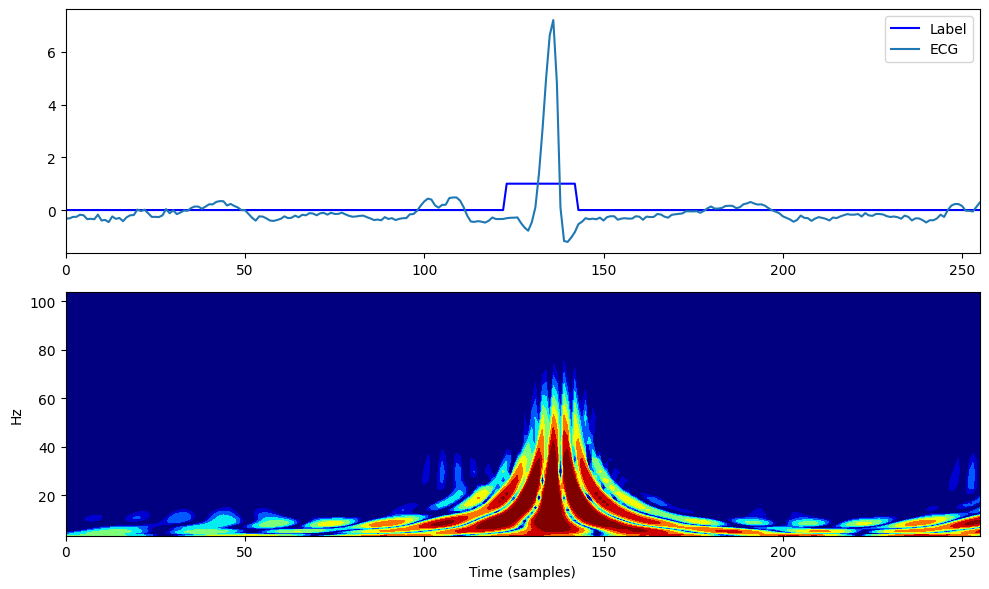

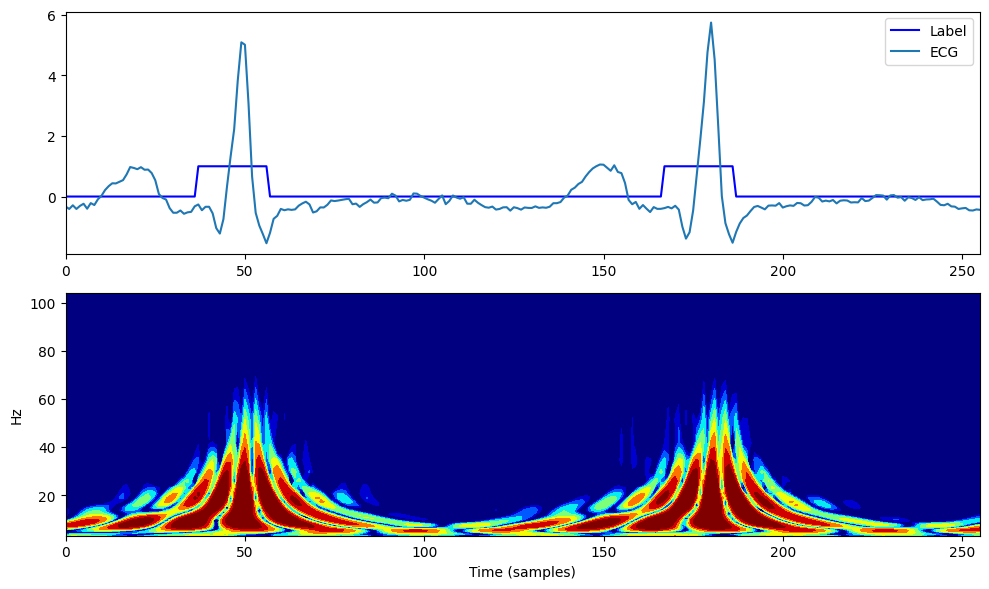

channel x001 has 2484 windows


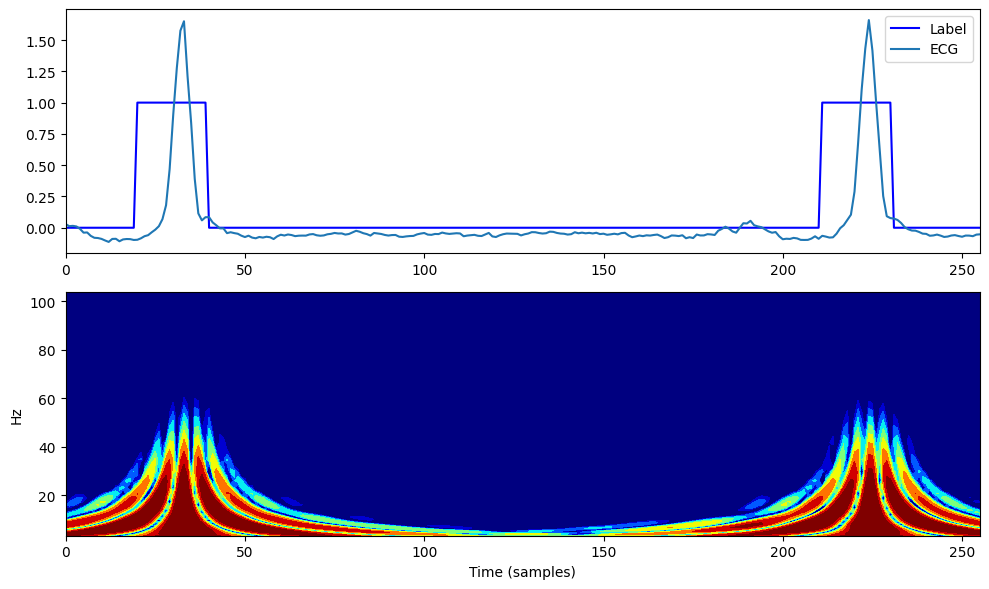

channel x002 has 2484 windows


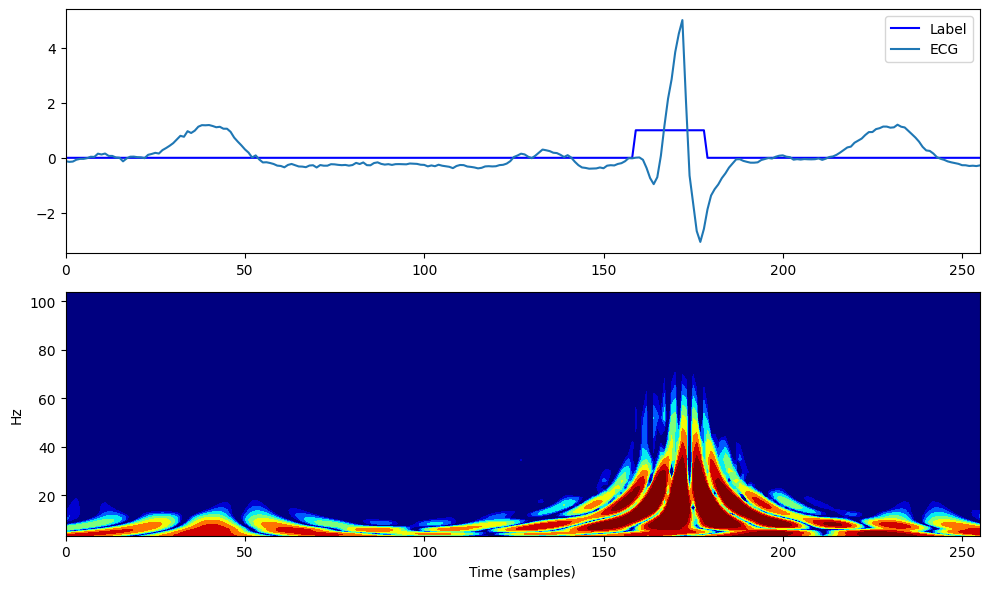

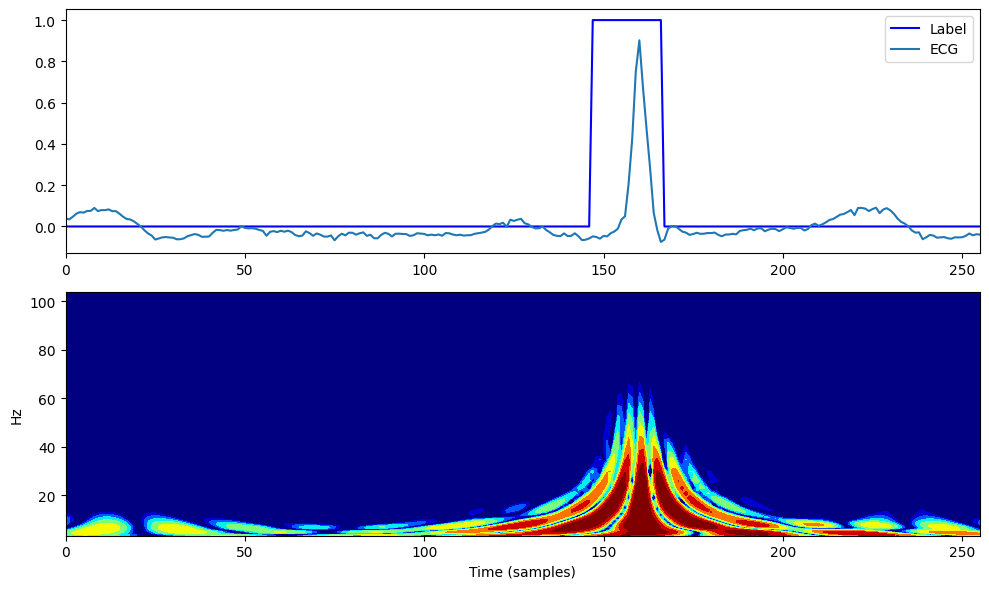

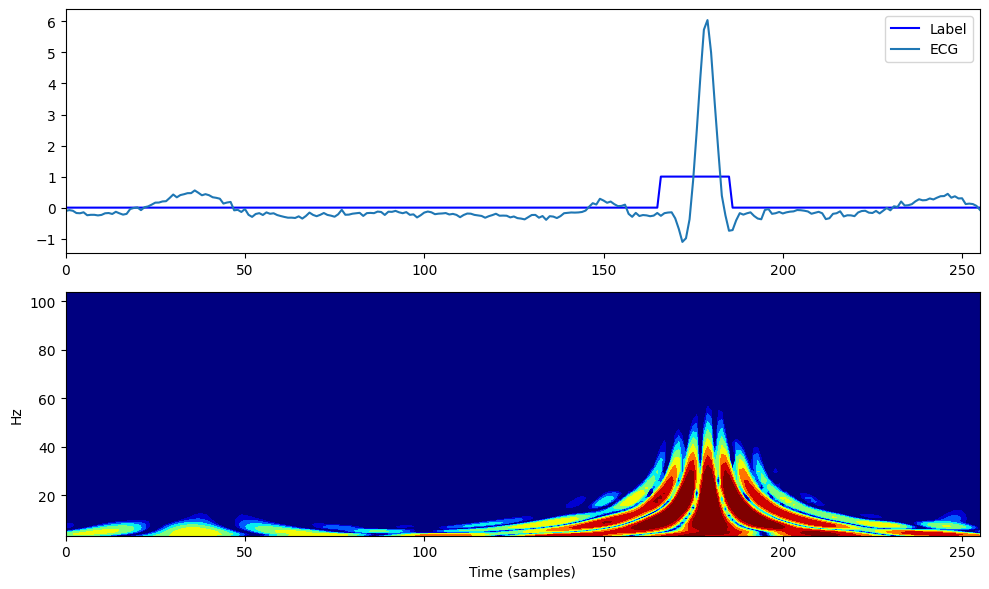

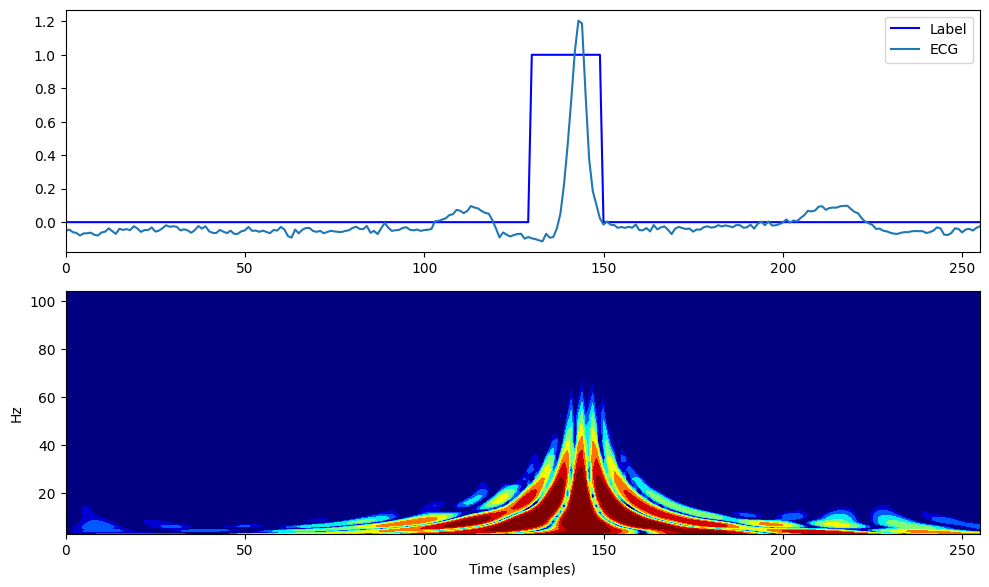

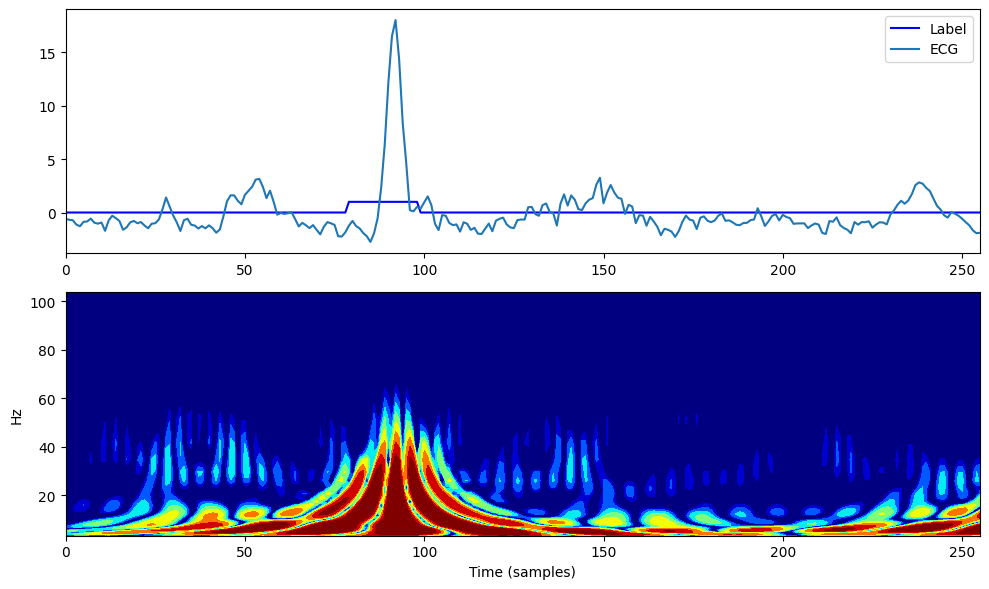

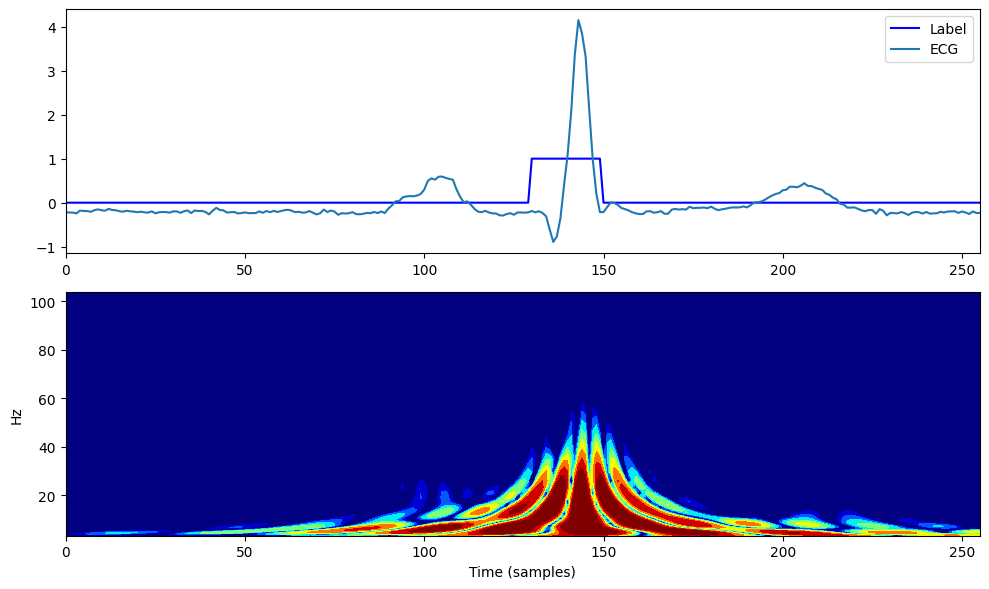

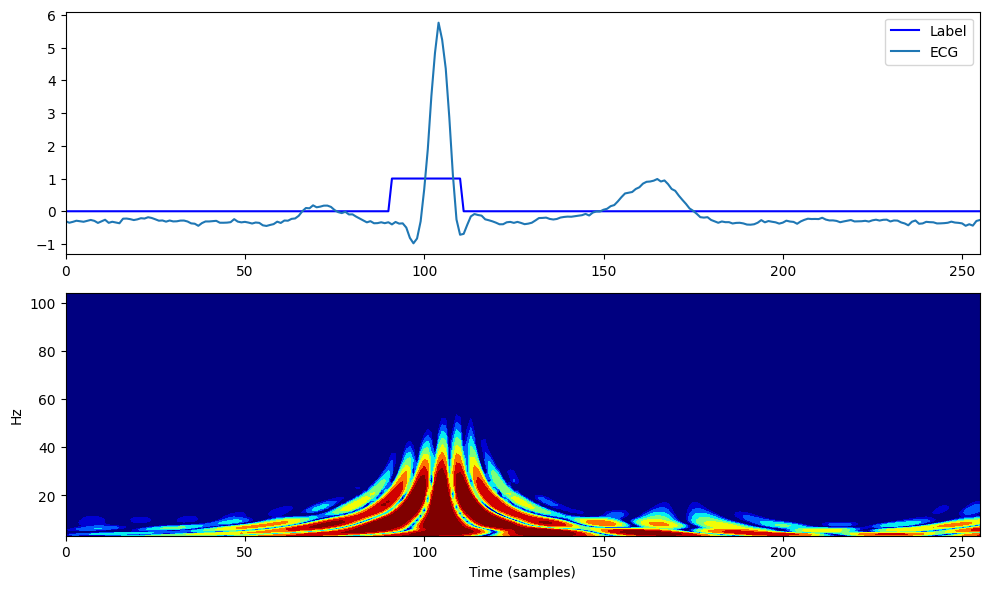

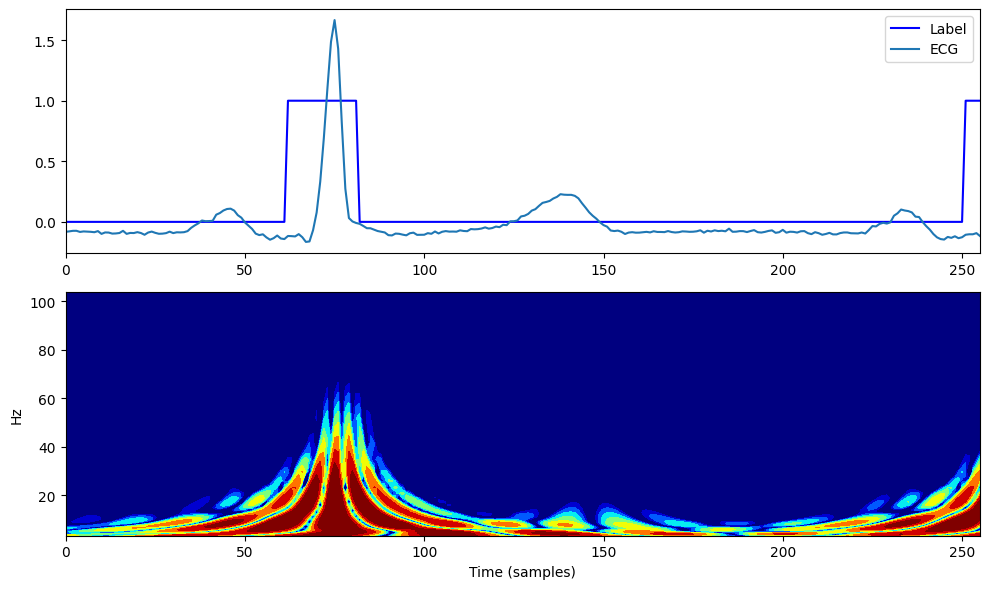

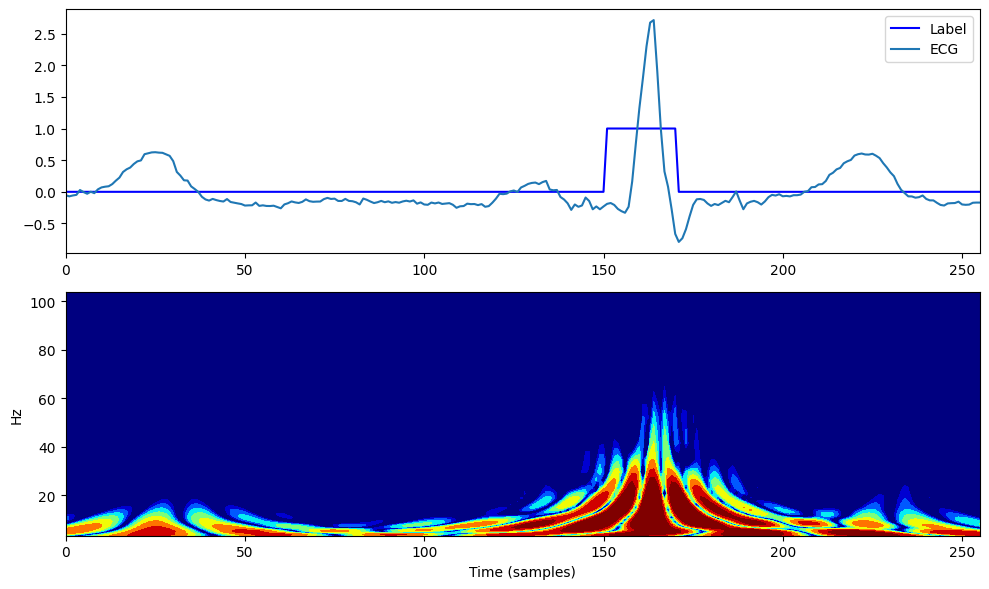

channel x011 has 2484 windows


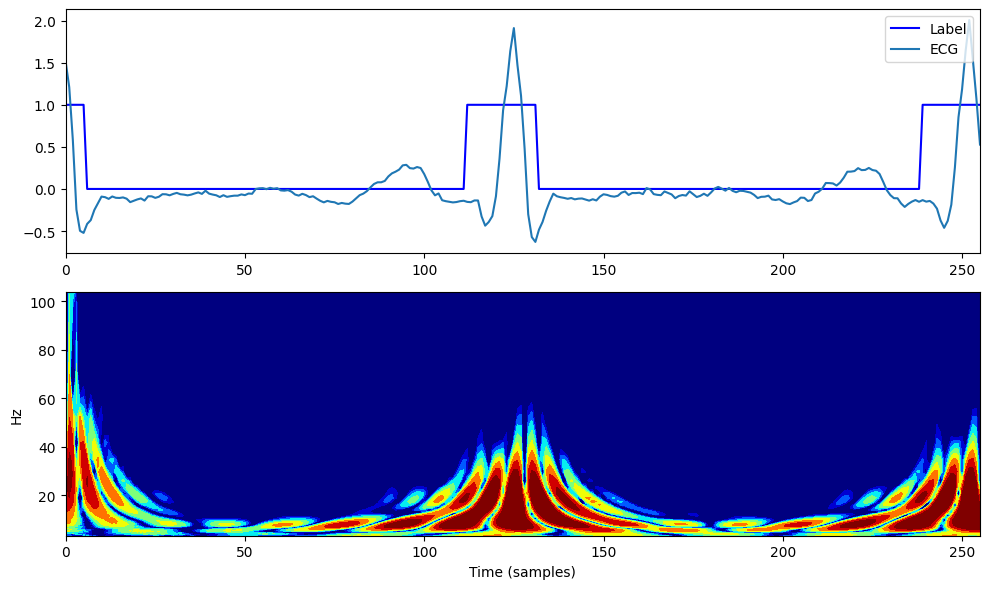

total number of windows: 29874


In [6]:
import gc
#window the data
RATIO = 0.9
#从1-13中random选择3个数
import random
random.seed(42)
channels = random.sample(range(1, 13), 3)
#将3个数转换成x00n的形式
channel_str = ['x00'+str(i) if i<10 else 'x0'+str(i) for i in channels]
print(channel_str)

train_sot,train_far,train_hex,train_nex= None,None,None,None
test_sot,test_far,test_hex,test_nex= None,None,None,None

continuous=True
ACTIVITY='rest'


#Faros
if continuous:
    windows_hex = []
    windows_hex_test = []
    for index,row in hex.iterrows():
        #print(row)
        temp = get_windows(row, activity=ACTIVITY)
        #如果记录属于CHANELS中的一个
        if index in channels:
            #合并
            windows_hex_test.extend(temp)
            #save the data
            unit_test = pd.DataFrame(temp)
            unit_test.to_pickle('test_%s.pkl' % channel_str[channels.index(index)], protocol=4)
            #print len of data
            print('channel %s has %i windows' % (channel_str[channels.index(index)], len(unit_test)))
        else:
            windows_hex.extend(temp)

    train_hex = pd.DataFrame(windows_hex)
    test_hex = pd.DataFrame(windows_hex_test)
    #free up memory
    windows_hex_raw, windows_hex, windows_hex_test = None, None, None
    gc.collect()
else:
    windows_hex_train = []
    windows_hex_test = []
    for index,row in hex.iterrows():
        temp=get_windows(row, activity=ACTIVITY)
        #切分数据集+合并
        pivot=int(len(temp)*RATIO)
        windows_hex_train.extend(temp[0:pivot])
        windows_hex_test.extend(temp[pivot:])
    train_hex = pd.DataFrame(windows_hex_train)
    test_hex = pd.DataFrame(windows_hex_test)

#free up memory
hex = None
gc.collect()


"""
#Sot
windows_sot = sot.apply(get_windows, activity='raw', axis=1)
windows_sot = pd.DataFrame(windows_sot)
windows_sot = pd.DataFrame([item for sublist in windows_sot.values for item in sublist[0]])
train_sot = windows_sot.iloc[0:int(len(windows_sot)*RATIO)]
test_sot = windows_sot.iloc[int(len(windows_sot)*RATIO)+1:]

#Nex
windows_nex = nex.apply(get_windows, activity='raw', axis=1)
windows_nex = pd.DataFrame(windows_nex)
windows_nex = pd.DataFrame([item for sublist in windows_nex.values for item in sublist[0]])
train_nex = windows_nex.iloc[0:int(len(windows_nex)*RATIO)]
test_nex = windows_nex.iloc[int(len(windows_nex)*RATIO)+1:]

#Hex
windows_hex = hex.apply(get_windows, activity='raw', axis=1)
windows_hex = pd.DataFrame(windows_hex)
windows_hex = pd.DataFrame([item for sublist in windows_hex.values for item in sublist[0]])
train_hex = windows_hex.iloc[0:int(len(windows_hex)*RATIO)]
test_hex = windows_hex.iloc[int(len(windows_hex)*RATIO)+1:]
"""

#combine the all channels
train = pd.concat((train_sot,train_far,train_hex,train_nex)).reset_index(drop=True)
train.to_pickle('train.pkl', protocol=4)
len_train=len(train)
train=None
gc.collect()
test = pd.concat((test_sot,test_far,test_hex,test_nex)).reset_index(drop=True)
test.to_pickle('test.pkl', protocol=4)
len_test=len(test)
test=None
gc.collect()

print('total number of windows: %i' % (len_train+len_test))

